<a href="https://colab.research.google.com/github/mobarakol/computer_vision_tutorial/blob/main/3D_reconstruction_depth_pose_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nianticlabs/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 21.33 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [2]:
!pip -q install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 117.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.4 MB/s eta 0:00:00


In [3]:
# import gdown
# url = 'https://drive.google.com/uc?id=1-WUCGHRf3kF4dXbHjHnl56TMsdQA_d4m'
# gdown.download(url,'endonasal_data.zip',quiet=True)
# !unzip -q endonasal_data.zip

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ids = ['1-WUCGHRf3kF4dXbHjHnl56TMsdQA_d4m']
zip_files = ['endonasal_data.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    if zip_file[-3:] == 'zip':
        !unzip -q $zip_file

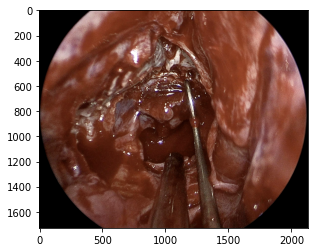

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open("/content/endonasal_data/2.png"))

/content/monodepth2
-> Loading model from  models/mono+stereo_640x192
   Loading pretrained encoder
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved predictions to:
   - /content/endonasal_data/1_disp.jpeg
   - /content/endonasal_data/1_disp.npy
-> Done!
/content


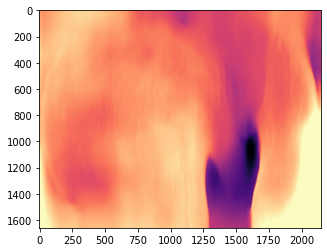

(<matplotlib.image.AxesImage at 0x7f69bea495b0>, None)

In [16]:
%cd monodepth2
!python test_simple.py --image_path /content/endonasal_data/1.png --model_name mono+stereo_640x192
%cd ..
plt.imshow(Image.open("/content/endonasal_data/1_disp.jpeg")), plt.show()

In [2]:
!pip -q install transformers
from transformers import DPTFeatureExtractor, DPTForDepthEstimation

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

/usr/local/lib/python3.9/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


sample size: 8


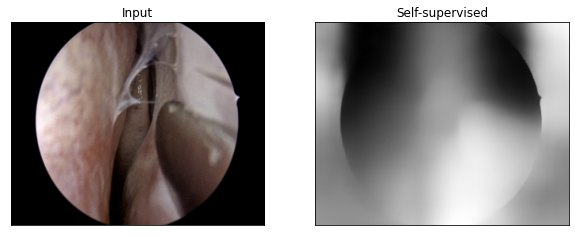

In [3]:
from glob import glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import gdown
import os
class TestDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        # depth = tifffile.imread(self.path_depth[i])[:,:,2]
        img = Image.open(self.path_depth[i]).convert('RGB')
        # img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

#(1024, 1280, 3)
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

path_test = glob('endonasal_data/*.png')
dataset_test = TestDataset(path_depth=path_test, transform=transform_test)
print('sample size:',len(dataset_test))

#DPT
image_raw = transforms.ToPILImage()(dataset_test[0])#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
# depth_raw = transforms.ToPILImage()(dataset_test[0][1])#[None]
# depth_gt = depth_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
encoding = feature_extractor(image, return_tensors="pt")
with torch.no_grad():
    outputs = depth_estimation(**encoding)
    # print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 2
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[0].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Self-supervised');

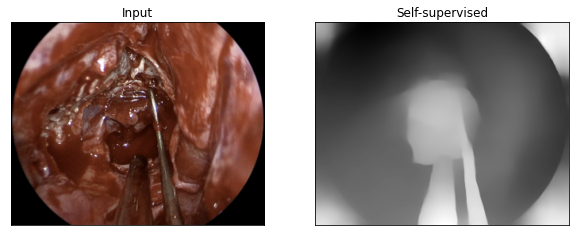

In [20]:
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm

i = 7
image_raw = transforms.ToPILImage()(dataset_test[i])#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
# depth_raw = transforms.ToPILImage()(dataset_test[0][1])#[None]
# depth_gt = depth_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
encoding = feature_extractor(image, return_tensors="pt")
with torch.no_grad():
    outputs = depth_estimation(**encoding)
    # print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 2
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[i].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Self-supervised');

vmax = np.percentile(output, 95)
normalizer = mpl.colors.Normalize(vmin=output.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
colormapped_im = (mapper.to_rgba(output)[:, :, :3] * 255).astype(np.uint8)
im = pil.fromarray(colormapped_im)

name_dest_im = os.path.join('disp', "{}_disp.jpeg".format(os.path.basename(path_test[i]).split('.')[0]))
im.save(name_dest_im)

In [5]:
path_test

['endonasal_data/a3.png',
 'endonasal_data/1.png',
 'endonasal_data/a4.png',
 'endonasal_data/a1.png',
 'endonasal_data/a5.png',
 'endonasal_data/a2.png',
 'endonasal_data/3.png',
 'endonasal_data/2.png']

In [23]:

import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


# rgbd
disp = np.array(Image.open("/content/disp/{}_disp.jpeg".format(os.path.basename(path_test[i]).split('.')[0])))
img = Image.open("/content/endonasal_data/{}.png".format(os.path.basename(path_test[i]).split('.')[0])).convert('RGB')
img = np.array(transforms.Resize((256, 320))(img))
# disp = np.array(Image.open("/content/disp/1_disp.jpeg"))
# img = np.array((Image.open("/content/endonasal_data/1.png").convert('RGB')))
print(disp.shape, img.shape)
depth_o3d = o3d.geometry.Image(disp)
image_o3d = o3d.geometry.Image(img)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# intrinsic
h = int(disp.shape[0])
w = int(disp.shape[1])
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
# camera_intrinsic.set_intrinsics(w, h, 100, 100, w/2, h/2)#500, 500, 640,512
camera_intrinsic.set_intrinsics(w, h, 200, 150, w/2, h/2)#500, 500, 640,512
# camera_intrinsic.set_intrinsics(w, h, 1035, 1035, 597, 520)#1035, 1035, 597,520
print('intrinsic:\n', camera_intrinsic.intrinsic_matrix)

# invalidate existing normals
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))  
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
pcd.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 1000.]))
pcd.transform([[1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])
pcd.transform([[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]) 

# run Poisson surface reconstruction
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_raw, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=10, width=0, scale=1.1, linear_fit=True)

voxel_size = max(mesh_raw.get_max_bound() - mesh_raw.get_min_bound()) / 256
print(f'voxel_size = {voxel_size:e}')
mesh = mesh_raw.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)

# vertices_to_remove = densities < np.quantile(densities, 0.001)
# mesh.remove_vertices_by_mask(vertices_to_remove)
bbox = pcd.get_axis_aligned_bounding_box() 
mesh_crop = mesh.crop(bbox)
mesh_crop = o3d.geometry.TriangleMesh.compute_triangle_normals (mesh_crop)
img_path = "pcd" # 'monodepth2/assets/pcd'
gltf_path = f'./{img_path}.gltf'
stl_path = f'./{img_path}.stl'
o3d.io.write_triangle_mesh("pcd.gltf", mesh_crop, write_triangle_uvs=True)
o3d.io.write_triangle_mesh("pcd.stl", mesh_crop, write_triangle_uvs=True) #ply/stl/obj/off/gltf
mesh = o3d.io.read_triangle_mesh('/content/pcd.stl')
print(mesh)
# o3d.visualization.draw_geometries([mesh_crop])

from google.colab import files

# files.download('/content/pcd.stl')
files.download('/content/pcd.gltf')

(256, 320, 3) (256, 320, 3)
intrinsic:
 [[200.   0. 160.]
 [  0. 150. 128.]
 [  0.   0.   1.]]
[Open3D DEBUG] Input Points / Samples: 81912 / 71725
[Open3D DEBUG] #   Got kernel density: 0.08643102645874023 (s), 2804.7421875 (MB) / 3343.7890625 (MB) / 3439 (MB)
[Open3D DEBUG] #     Got normal field: 0.22194504737854004 (s), 2804.7421875 (MB) / 3343.7890625 (MB) / 3439 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.254844e-05 / 1.027868e+00
[Open3D DEBUG] #       Finalized tree: 0.31337404251098633 (s), 2804.7421875 (MB) / 3343.7890625 (MB) / 3439 (MB)
[Open3D DEBUG] #  Set FEM constraints: 1.5591120719909668 (s), 2804.7421875 (MB) / 3343.7890625 (MB) / 3439 (MB)
[Open3D DEBUG] #Set point constraints: 0.15587997436523438 (s), 2804.7421875 (MB) / 3343.7890625 (MB) / 3439 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 1407526 / 1216840 / 391761
[Open3D DEBUG] Memory Usage: 2804.742 MB
[Open3D DEBUG] # Linear system solved: 1.5381510257720947 (s), 2804.7421875 (MB) / 33

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip -q install numpy-stl

In [ ]:
!mkdir images

<ipython-input-11-7d5967275589>:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


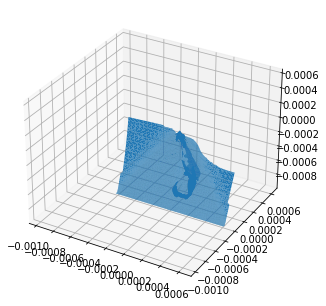

In [ ]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
mesh = mesh.Mesh.from_file('pcd.stl') # Mesh with 77255 items
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh.vectors))

# Auto scale to the mesh size
points = mesh.points #ndarray with shape (77255, 9)
scale = mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)
plt.show()